In [31]:
library(doParallel)
library(igraph)
library(progress)
library(foreach)
library(ggplot2)
library(pbapply) 

In [32]:
hamilton <- function(g, state, J = 1.0, H = 0.0) {
    E <- 0.0
    for (e in E(g)) {
        i <- ends(g, e)[1]
        j <- ends(g, e)[2]
        E <- E - J * state[i] * state[j]
    }
    if (H != 0) {
        for (n in V(g)) {
            E <- E - H * state[n]
        }
    }
    return(E)
}

metropolis.update <- function(g, state, T) {
    for (i in 1:vcount(g)) {
        n <- sample(vcount(g), 1)
        s <- state[n]
        dE <- 0

        for (neighbor in neighbors(g, n)) {
            dE <- dE + state[neighbor]
        }
        dE <- 2 * s * dE


        if (runif(1) < exp(-dE / T)) {
            state[n] <- - s
        }
    }
    return(state)
}

simulation <- function(g, state, T.i = 1e1, T.f = 0.0 , nsteps, adjust.T = TRUE) {
    if (T.i < T.f) {
        warning(sprintf("setting T.i to T.f and disabling temperature scaling because T.i %f < T.f %f", T.i, T.f))
        T.i <- T.f
        adjust.T <- FALSE
    }
  
    T.f <- ifelse(T.f == 0, T.i * 1e-10, T.f)
    T.i <- ifelse(T.i == 0, 1e-10, T.i)
    T <- T.i
    Tdamp <- exp(log(T.f / T.i) / nsteps)
    accum <- numeric(4)

    for (i in 1:nsteps) {
        if (adjust.T) {
            T <- T * Tdamp
        }
    state <- metropolis.update(g, state, T)

    M <- sum(state)
    E <- hamilton(g, state)

    accum[1] <- accum[1] + E
    accum[2] <- accum[2] + E^2
    accum[3] <- accum[3] + M
    accum[4] <- accum[4] + M^2
    }
  
    # Normalize accumulators
    accum <- accum / nsteps
    accum[1:2] <- accum[1:2] / gsize(g)
    accum[2] <- accum[2] / gsize(g)
    accum[3:4] <- accum[3:4] / gsize(g)
    accum[4] <- accum[4] / gsize(g)
    
    return(list(state = state, accum = accum))
}

equilibrate <- function(g , state, T = 1.0, steps = 100) {
    return(simulation(g, state, T.i = T, nsteps = steps, adjust.T = FALSE))
}

compute_critic_T <- function(g) {
    k.mean <- mean(degree(g))
    k.2.mean <- mean(degree(g)^2)
    T.c <- 1/(-0.5*log(1-2*k.mean/k.2.mean))
    return(T.c)
}



In [42]:
# Define parameters
N <- 400
#p <- 0.05
nsamples <- 20

g <- sample_pa(N , directed = FALSE)
T.c <- compute_critic_T(g)

Ts <- seq(T.c*1e-5, 2.5*T.c, length.out = 40)

# Parallelization setup
num_cores <- detectCores() - 1  # Use all cores except one
cl <- makeCluster(num_cores)

# Export the necessary variables and functions to the cluster
clusterExport(cl, c("g", "Ts", "nsamples", "simulation", "equilibrate", "compute_critic_T", "hamilton", "metropolis.update"))
clusterEvalQ(cl, library(igraph))

# Parallelized simulation function for a single temperature
sim_parallel <- function(T, nsamples, nsim, neq) {
    E_results <- numeric(nsamples)
    mag_results <- numeric(nsamples)
    chi_results <- numeric(nsamples)
    Cv_results <- numeric(nsamples)

    for (s in 1:nsamples) {
        sv <- rep(1, vcount(g))  # Initialize the spin state with all 1's

        # Perform simulation and equilibration
        results.1 <- simulation(g, sv, T.i = T + 1, T.f = T, nsteps = nsim)
        results.2 <- equilibrate(g, results.1$state, T, neq)

        # Store results
        E_results[s] <- results.2$accum[1]
        mag_results[s] <- results.2$accum[3]
        chi_results[s] <- (results.2$accum[4] - results.2$accum[3]^2) / T
        Cv_results[s] <- (results.2$accum[2] - results.2$accum[1]^2) / T^2
    }

    return(list(E_results = E_results, mag_results = mag_results, chi_results = chi_results, Cv_results = Cv_results))
}

# Run the simulation for each temperature in parallel with progress bar
results_list <- pblapply(Ts, sim_parallel, cl = cl)

# Stop the cluster once the computation is done
stopCluster(cl)

# Organize results from the parallel run
Es <- lapply(results_list, function(x) x$E_results)
mags <- lapply(results_list, function(x) x$mag_results)
chis <- lapply(results_list, function(x) x$chi_results)
Cvs <- lapply(results_list, function(x) x$Cv_results)

# Calculate means and variances
E_mean <- sapply(Es, mean)
E_var <- sapply(Es, sd)
M_mean <- sapply(mags, mean)
M_var <- sapply(mags, sd)
chi_mean <- sapply(chis, mean)
chi_var <- sapply(chis, sd)
Cv_mean <- sapply(Cvs, mean)
Cv_var <- sapply(Cvs, sd)

[[1]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[6]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[7]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[8]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[9]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[10]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[11]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

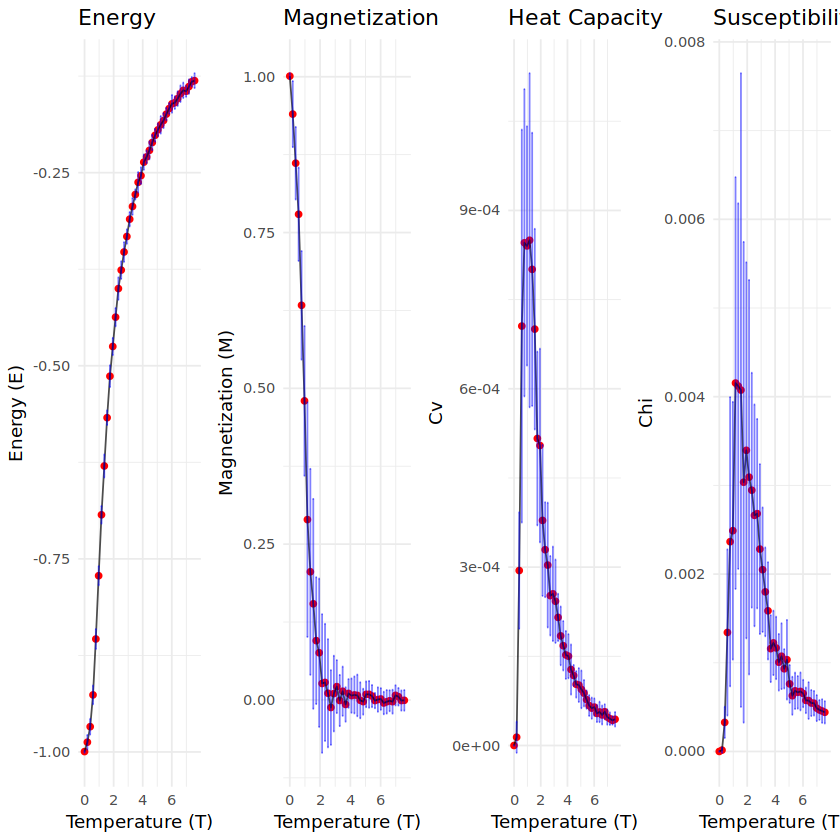

In [47]:
# Load necessary libraries
library(ggplot2)
library(gridExtra)

# Assuming Ts, E_mean, E_var, M_mean, M_var, Cv_mean, Cv_var, chi_mean, chi_var, and T.c are predefined vectors/values

# Create individual plots with vertical dashed line at T.c
p1 <- ggplot(data.frame(Ts, E_mean, E_var), aes(x = Ts, y = E_mean)) +
  geom_point(color = "red") +
  geom_line(color = "black", alpha = 0.7) +
  geom_errorbar(aes(ymin = E_mean - E_var, ymax = E_mean + E_var), width = 0.1, color = "blue", alpha = 0.5) +
  #geom_vline(xintercept = T.c, linetype = "dashed", color = "green") +  # Vertical dashed line at T.c
  labs(title = "Energy", x = "Temperature (T)", y = "Energy (E)") +
  theme_minimal()

p2 <- ggplot(data.frame(Ts, M_mean, M_var), aes(x = Ts, y = M_mean)) +
  geom_point(color = "red") +
  geom_line(color = "black", alpha = 0.7) +
  geom_errorbar(aes(ymin = M_mean - M_var, ymax = M_mean + M_var), width = 0.1, color = "blue", alpha = 0.5) +
  #geom_vline(xintercept = T.c, linetype = "dashed", color = "green") +  # Vertical dashed line at T.c
  labs(title = "Magnetization", x = "Temperature (T)", y = "Magnetization (M)") +
  theme_minimal()

p3 <- ggplot(data.frame(Ts, Cv_mean, Cv_var), aes(x = Ts, y = Cv_mean)) +
  geom_point(color = "red") +
  geom_line(color = "black", alpha = 0.7) +
  geom_errorbar(aes(ymin = Cv_mean - Cv_var, ymax = Cv_mean + Cv_var), width = 0.1, color = "blue", alpha = 0.5) +
  #geom_vline(xintercept = T.c, linetype = "dashed", color = "green") +  # Vertical dashed line at T.c
  labs(title = "Heat Capacity", x = "Temperature (T)", y = "Cv") +
  theme_minimal()

p4 <- ggplot(data.frame(Ts, chi_mean, chi_var), aes(x = Ts, y = chi_mean)) +
  geom_point(color = "red") +
  geom_line(color = "black", alpha = 0.7) +
  geom_errorbar(aes(ymin = chi_mean - chi_var, ymax = chi_mean + chi_var), width = 0.1, color = "blue", alpha = 0.5) +
  #geom_vline(xintercept = T.c, linetype = "dashed", color = "green") +  # Vertical dashed line at T.c
  labs(title = "Susceptibility", x = "Temperature (T)", y = "Chi") +
  theme_minimal()

# Arrange the 4 plots into a 2x2 grid
ggsave("IM_scale_free.png", grid.arrange(p1, p2, p3, p4, ncol = 4, nrow = 1),
       width = 12, height = 4, units = "in")



In [54]:
library(igraph)
library(parallel)
library(pbapply)

# Define parameters
sz <- 200
probs <- c(0.001, 0.005, 0.01, 0.03, 0.05, 0.08, 0.1)
nsamples <- 10
Ts <- seq(0, 10, length.out=50)

E_mean <- vector("list", length(Ts))
E_var <- vector("list", length(Ts))
M_mean <- vector("list", length(Ts))
M_var <- vector("list", length(Ts))
chi_mean <- vector("list", length(Ts))
chi_var <- vector("list", length(Ts))
Cv_mean <- vector("list", length(Ts))
Cv_var <- vector("list", length(Ts))

# Set up parallel cluster
num_cores <- detectCores() - 1  # Use all cores except one
cl <- makeCluster(num_cores)

# Function to run simulation for a single temperature
sim_parallel <- function(T_p) {
    T <- T_p[1]  # Extract the temperature
    p <- T_p[2]  # Extract the probability
    
    Es <- numeric(nsamples)
    mags <- numeric(nsamples)
    chis <- numeric(nsamples)
    Cvs <- numeric(nsamples)
    
    for (s in 1:nsamples) {
        g <- erdos.renyi.game(sz, p = p, directed = FALSE)
        sv <- rep(1, vcount(g))  # Initialize spins
        
        # Perform simulation and equilibration
        results.1 <- simulation(g, sv, T.i = T + 1, T.f = T, nsteps = 15)
        results.2 <- equilibrate(g, results.1$state, T, 10)

        # Store results
        Es[s] <- results.2$accum[1]
        mags[s] <- results.2$accum[3]
        chis[s] <- (results.2$accum[4] - results.2$accum[3]^2) / T
        Cvs[s] <- (results.2$accum[2] - results.2$accum[1]^2) / T^2
    }
    
    return(list(E = Es, M = mags, Chi = chis, Cv = Cvs))
}

# Export necessary variables and functions to the cluster, including sim_parallel
clusterExport(cl, c("sz", "nsamples", "simulation", "equilibrate", 
                    "erdos.renyi.game", "vcount", "sim_parallel",
                    "metropolis.update", "hamilton"))

# Ensure igraph is loaded on each worker node
clusterEvalQ(cl, library(igraph))

# Create a progress bar
pb <- txtProgressBar(min = 0, max = length(probs) * length(Ts), style = 3)

# Main loop over probabilities
for (p_index in seq_along(probs)) {
    p <- probs[p_index]
    
    # Create a list of (T, p) pairs for parallel execution
    T_p_list <- Map(c, Ts, rep(p, length(Ts)))
    
    # Run the simulation for all temperatures in parallel
    results_list <- pblapply(T_p_list, sim_parallel, cl = cl)
    
    # Extract results
    Es <- lapply(results_list, function(x) x$E)
    mags <- lapply(results_list, function(x) x$M)
    chis <- lapply(results_list, function(x) x$Chi)
    Cvs <- lapply(results_list, function(x) x$Cv)

    # Calculate means and variances
    E_mean[[p_index]] <- sapply(Es, mean)
    E_var[[p_index]] <- sapply(Es, sd)
    M_mean[[p_index]] <- sapply(mags, mean)
    M_var[[p_index]] <- sapply(mags, sd)
    chi_mean[[p_index]] <- sapply(chis, mean)
    chi_var[[p_index]] <- sapply(chis, sd)
    Cv_mean[[p_index]] <- sapply(Cvs, mean)
    Cv_var[[p_index]] <- sapply(Cvs, sd)
    
    setTxtProgressBar(pb, p_index * length(Ts))
}

close(pb)

# Stop the cluster once the computation is done
stopCluster(cl)




[[1]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[6]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[7]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[8]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[9]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[10]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[11]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

  |======================================================================| 100%


Warning message:
“Removed 7 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_point()`).”


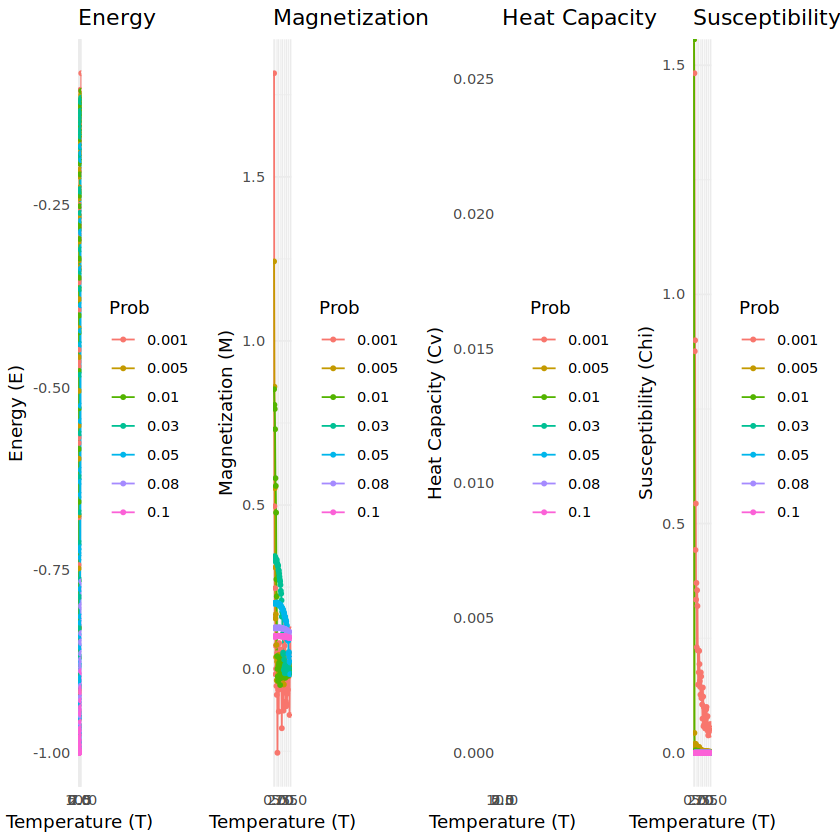

In [58]:
library(ggplot2)
library(gridExtra)

# Assuming the lists: E_mean, M_mean, Cv_mean, chi_mean, Ts, and probs are defined

# Prepare the data frames for each magnitude
prepare_data <- function(values_list, Ts, probs) {
  data <- do.call(rbind, lapply(seq_along(probs), function(i) {
    data.frame(Ts = Ts, Value = values_list[[i]], Prob = as.factor(probs[i]))
  }))
  return(data)
}

# Prepare data for each magnitude
E_data <- prepare_data(E_mean, Ts, probs)
M_data <- prepare_data(M_mean, Ts, probs)
Cv_data <- prepare_data(Cv_mean, Ts, probs)
Chi_data <- prepare_data(chi_mean, Ts, probs)

# Plot Energy
p1 <- ggplot(E_data, aes(x = Ts, y = Value, color = Prob, group = Prob)) +
  geom_line() +
  geom_point(size = 1) +
  labs(title = "Energy", x = "Temperature (T)", y = "Energy (E)") +
  theme_minimal()

# Plot Magnetization
p2 <- ggplot(M_data, aes(x = Ts, y = Value, color = Prob, group = Prob)) +
  geom_line() +
  geom_point(size = 1) +
  labs(title = "Magnetization", x = "Temperature (T)", y = "Magnetization (M)") +
  theme_minimal()

# Plot Heat Capacity
p3 <- ggplot(Cv_data, aes(x = Ts, y = Value, color = Prob, group = Prob)) +
  geom_line() +
  geom_point(size = 1) +
  labs(title = "Heat Capacity", x = "Temperature (T)", y = "Heat Capacity (Cv)") +
  theme_minimal()

# Plot Susceptibility
p4 <- ggplot(Chi_data, aes(x = Ts, y = Value, color = Prob, group = Prob)) +
  geom_line() +
  geom_point(size = 1) +
  labs(title = "Susceptibility", x = "Temperature (T)", y = "Susceptibility (Chi)") +
  theme_minimal()

# Arrange the plots in a 2x2 grid
ggsave("IM_ER.png", grid.arrange(p1, p2, p3, p4, ncol = 4, nrow = 1),
       width = 15, height = 3, units = "in")
